In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 하이퍼파라미터 설정
batch_size = 64
num_epochs = 20
noise_factor = 0.5  # 노이즈 강도 (0.0 ~ 1.0)
# 변경 가능
learning_rate = 1e-3

Using device: cuda


In [38]:
def calculate_score(mse_loss):
    """
    MSE Loss를 100점 만점 점수로 환산하는 함수
    - 기준: MSE 0.02 (베이스라인) -> 약 80점
    - 공식: 100 - (MSE * 1000)
    """
    score = 100 - (mse_loss * 1000)
    return max(0.0, score)

In [39]:
# 데이터 로더
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
# 모델 정의
class Model(nn.Module):
    def __init__(self, ch=64, depth=8):
        super().__init__()
        layers = []
        layers += [nn.Conv2d(1, ch, 3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(depth - 2):
            layers += [nn.Conv2d(ch, ch, 3, padding=1),
                       nn.BatchNorm2d(ch),
                       nn.ReLU(inplace=True)]
        layers += [nn.Conv2d(ch, 1, 3, padding=1)]
        self.net = nn.Sequential(*layers)

        nn.init.zeros_(self.net[-1].weight)
        if self.net[-1].bias is not None:
            nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        noise_pred = self.net(x)
        return x - noise_pred

In [ ]:
model = Model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #변경 가능

In [42]:
print("학습 시작...")
model.train() # 학습 모드 전환

for epoch in range(num_epochs):
    train_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        # 이미지에 노이즈 추가
        noisy_img = img + noise_factor * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        # Forward (모델 예측)
        output = model(noisy_img)

        # Loss 계산
        loss = criterion(output, img)

        # Backward (역전파 및 가중치 업데이트)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}")

학습 시작...
Epoch [1/20], Train Loss: 0.0122
Epoch [2/20], Train Loss: 0.0100
Epoch [3/20], Train Loss: 0.0097
Epoch [4/20], Train Loss: 0.0095
Epoch [5/20], Train Loss: 0.0093
Epoch [6/20], Train Loss: 0.0092
Epoch [7/20], Train Loss: 0.0092
Epoch [8/20], Train Loss: 0.0091
Epoch [9/20], Train Loss: 0.0091
Epoch [10/20], Train Loss: 0.0090
Epoch [11/20], Train Loss: 0.0090
Epoch [12/20], Train Loss: 0.0089
Epoch [13/20], Train Loss: 0.0089
Epoch [14/20], Train Loss: 0.0088
Epoch [15/20], Train Loss: 0.0088
Epoch [16/20], Train Loss: 0.0088
Epoch [17/20], Train Loss: 0.0088
Epoch [18/20], Train Loss: 0.0087
Epoch [19/20], Train Loss: 0.0087
Epoch [20/20], Train Loss: 0.0087


In [43]:
model.eval() # 평가 모드 전환
total_test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)

        # 테스트 데이터에도 동일한 노이즈 추가
        noisy_img = img + noise_factor * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        output = model(noisy_img)
        loss = criterion(output, img) # MSE Loss 계산
        total_test_loss += loss.item()

# 최종 평균 MSE 계산 및 점수 환산
avg_test_loss = total_test_loss / len(test_loader)
final_score = calculate_score(avg_test_loss)


print(f"최종 Test MSE Loss: {avg_test_loss:.5f}")
print(f"최종 점수 (Score): {final_score:.2f} / 100점")

최종 Test MSE Loss: 0.00865
최종 점수 (Score): 91.35 / 100점


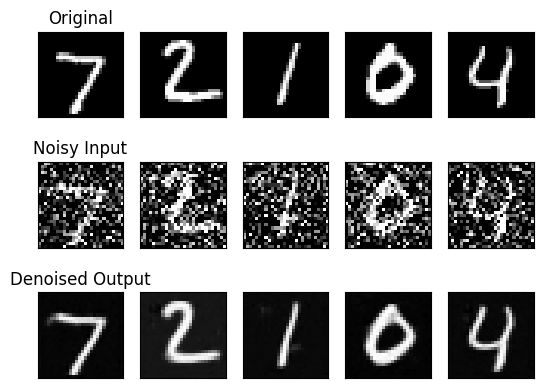

In [44]:
model.eval()
with torch.no_grad():
    # 테스트 데이터 하나 가져오기
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images.to(device)

    # 노이즈 추가 및 모델 통과
    noisy_imgs = images + noise_factor * torch.randn_like(images)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    outputs = model(noisy_imgs)

    # CPU로 이동 (시각화용)
    images = images.cpu().numpy()
    noisy_imgs = noisy_imgs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # 시각화
    plt.figure()
    for i in range(5):
        # 1. 원본 이미지
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title('Original')

        # 2. 노이즈 이미지 (Input)
        ax = plt.subplot(3, 5, i + 1 + 5)
        plt.imshow(noisy_imgs[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title('Noisy Input')

        # 3. 복원된 이미지 (Output)
        ax = plt.subplot(3, 5, i + 1 + 10)
        plt.imshow(outputs[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title('Denoised Output')

    plt.show()